# COMP90051 Authorship Attribution 
----------
    
`1.` [Loading Data](#loading)

    1.1 Loading Packages
    1.2 Loading Train, Test



<a class="anchor" id="loading"></a>
# Loading Data

In [13]:
import re, pickle, os, string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np 
import pandas as pd 
import nltk
import string
import spacy
from profanity import profanity
from nltk.corpus import stopwords
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [14]:
train_data = None
test_data = None

def load_data():
    global train_data, test_data
    train_data = pd.read_csv('train_tweets.txt', delimiter="\t", header=None)
    test_data = pd.read_csv('test_tweets_unlabeled.txt', delimiter="\t", header = None)

load_data()
train_data.columns = ['Author', 'Tweet']
print(train_data)

        Author                                              Tweet
0         8746     @handle Let's try and catch up live next week!
1         8746  Going to watch Grey's on the big screen - Thur...
2         8746  @handle My pleasure Patrick....hope you are well!
3         8746  @handle Hi there! Been traveling a lot and lot...
4         8746  RT @handle Looking to Drink Clean & Go Green? ...
5         8746  RT @handle: Ft. Hood officials confirm the 2 o...
6         8746  RT @handle: Mickey Mouse is Getting a Make Ove...
7         8746           @handle How did u get the invite Justin?
8         8746  @handle I think I am still a good friend of he...
9         8746  @handle I remember! I am fine - how are u? Wha...
10        8746     @handle That's great - good for the coach!!!!!
11        8746  @handle I don't want to picture u sitting on i...
12        8746  @handle D- Thanks for the RTs....are you going...
13        8746           @handle Grrr....you must be going crazy!
14        

In [15]:
def load_pickle(filepath):
    documents_f = open(filepath, 'rb')
    file = pickle.load(documents_f)
    documents_f.close()
    
    return file

def save_pickle(data, filepath):
    save_documents = open(filepath, 'wb')
    pickle.dump(data, save_documents)
    save_documents.close()

In [16]:
def custom_tokenizer(nlp):
    infix_re = re.compile(r'''[.\?\:\;\...\‘\’\`\“\”\"\'~]''')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                token_match=None)
spacy_nlp = spacy.load("en")
spacy_nlp.tokenizer = custom_tokenizer(spacy_nlp)
nlp1 = spacy.load('en_core_web_lg')

stp = [word for word in list(stopwords.words('english') + [ "'s", "'m", "ca"])
        if word not in ["no", "not"] and word.rfind("n't") == -1]

class PreProcessor(object):
    '''Pre-processor which cleans text, lemmatises, removes stop words and punctuation, 
    returns df of processed text.'''

    def __init__(self):
        self._stopWordList = stp
        self._punct_removal = list(string.punctuation)
        self.sid = SentimentIntensityAnalyzer()

    def _tokenize_text(self, sample):
        '''tokenises sentences in order to lemmatise, remove stop words and punctuation, 
        returns string of processed text'''

        # get tokens using spacy
        tokens = spacy_nlp(sample)

        # lemmatising tokens
        tokens = [t.lemma_.strip()
                  if t.lemma_ != "-PRON-"
                  else t.lower_
                  for t in tokens]

        # stopword and punctuation removal
        tokens = [t.lower() for t in tokens
                  if (t not in self._stopWordList and t not in self._punct_removal)]

        processed_text = " ".join(tokens)
        return processed_text
    
    def remove_url(self, text):
        result = re.sub(r"http\S+", "", text)
        return result
    
    def check_url(self, text):
        url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text) 
        if len(url) != 0:
            return True
        return False
    
    def unique_words(self, words):
        word_count = len(words)
        unique_count = len(set(words))
        if word_count!=0:
            return unique_count / word_count
        return 0
    
    def mention(self, text):
        return set([re.sub(r"(\W+)$", "", j) for j in set([i for i in text.split() if i.startswith("@")])])
    
    def retweet(self, text):
        rt = 'rt'
        if rt in text:
            return True
        return False
    
    def hashtag(self, text):
        return set([re.sub(r"(\W+)$", "", j) for j in set([i for i in text.split() if i.startswith("#")])])
    
    def extract_emojis(self, text):
        happy = [':-)', ':-D', ':)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':^']
        sad = [':-(', ':(', ':\'-(', ':\'(', ':\'-)' ':\')', ':-|', ':-', ':{', ':[', ':\\', ':*',':&', ':<']
        for each in happy:
            if each in text:
                return 'Happy'
                break
                   
        for each in sad:
            if each in text:
                return 'Sad'
                break
        return ''
    
    def profanity_analysis(self, content):
        contain_profanity=profanity.contains_profanity(content)
        return contain_profanity
    
    def location_finder(self, text):
        doc = nlp1(text)
        for ent in doc.ents:
            if ent.label_ == 'GPE':
                 return ent.text
                 break
 
    def transform_text(self, data):
        
        '''applies the clean and tokenise methods to the texts, 
        encodes the target variable to numerical. 
        Option to set pickle to True to save clean df'''
        no_punct_translator=str.maketrans('','',string.punctuation)
        
        data['words'] = data['Tweet'].apply(lambda row: self.remove_url(str(row))).apply(lambda t: nltk.word_tokenize(t.translate(no_punct_translator).lower()))
        data['URL'] = data['Tweet'].apply(lambda row: self.check_url(str(row)))
        data['word_count'] = data['words'].apply(lambda words: len(words))
        data['sentence_length'] = data['words'].apply(lambda w: sum(map(len, w)))
        data['text_length'] = data['Tweet'].apply(lambda t: len(str(t)))
        data['sentiment'] = data['Tweet'].apply(lambda t: self.sid.polarity_scores(t)['compound'])
        data['punctuation_per_tweet'] = data['Tweet'].apply(lambda t: len(list(filter(lambda c: c in t, string.punctuation)))) / data['text_length']
        data['unique_ratio'] = data['words'].apply(lambda row: self.unique_words(row))
        data['avg_word_length'] = data['words'].apply(lambda words: sum(map(len, words)) / len(words) if len(words)!=0 else 0)
        data['mention'] = data['Tweet'].apply(lambda row: self.mention(str(row)))
        data['Retweet'] = data['words'].apply(lambda row: self.retweet(str(row)))
        data['Hashtag'] = data['Tweet'].apply(lambda row: self.hashtag(str(row)))
        data['emojis'] = data['Tweet'].apply(lambda row: self.extract_emojis(str(row)))
        data['profanity'] = data['words'].apply(lambda row: self.profanity_analysis(str(row)))
        data['location'] = data['Tweet'].apply(lambda row: self.location_finder(str(row)))
        return data
    
    def transform_text1(self, data):
        data['transform'] = data['words'].apply(lambda row: self._tokenize_text(str(row)))
        return data

In [17]:
train_data = load_pickle("train_data.p")

In [18]:
train_data

,Author,Tweet,words,URL,word_count,sentence_length,text_length,sentiment,punctuation_per_tweet,unique_ratio,avg_word_length,mention,Retweet,Hashtag,emojis,profanity,location,transform
0,8746,@handle Let's try and catch up live next week!,"[handle, lets, try, and, catch, up, live, next...",False,9,35,46,0.0000,0.065217,1.000000,3.888889,{@handle},False,{},,False,None,handle let try catch live next week
1,8746,Going to watch Grey's on the big screen - Thur...,"[going, to, watch, greys, on, the, big, screen...",False,10,49,66,0.0000,0.045455,1.000000,4.900000,{},False,{},,False,None,go watch grey big screen thursday indulgence
2,8746,@handle My pleasure Patrick....hope you are well!,"[handle, my, pleasure, patrickhope, you, are, ...",False,7,37,49,0.7263,0.061224,1.000000,5.285714,{@handle},False,{},,False,None,handle pleasure patrickhope well
3,8746,@handle Hi there! Been traveling a lot and lot...,"[handle, hi, there, been, traveling, a, lot, a...",False,25,100,132,0.4997,0.030303,0.960000,4.000000,{@handle},False,{},,False,None,handle hi travel lot lot come next month recov...
4,8746,RT @handle Looking to Drink Clean & Go Green? ...,"[rt, handle, looking, to, drink, clean, go, gr...",False,18,86,109,0.4019,0.036697,0.888889,4.777778,{@handle},True,{},,False,None,rt handle look drink clean go green purchase c...
5,8746,RT @handle: Ft. Hood officials confirm the 2 o...,"[rt, handle, ft, hood, officials, confirm, the...",False,17,86,105,-0.3400,0.028571,1.000000,5.058824,{@handle},True,{},,False,None,rt handle ft hood official confirm 2 soldier i...
6,8746,RT @handle: Mickey Mouse is Getting a Make Ove...,"[rt, handle, mickey, mouse, is, getting, a, ma...",True,10,43,76,0.0000,0.052632,0.900000,4.300000,{@handle},True,{},,False,None,rt handle mickey mouse get make handle
7,8746,@handle How did u get the invite Justin?,"[handle, how, did, u, get, the, invite, justin]",False,8,31,40,0.1531,0.050000,1.000000,3.875000,{@handle},False,{},,False,None,handle u get invite justin
8,8746,@handle I think I am still a good friend of he...,"[handle, i, think, i, am, still, a, good, frie...",False,12,40,55,0.8478,0.054545,0.916667,3.333333,{@handle},False,{},,False,None,handle think still good friend lol
9,8746,@handle I remember! I am fine - how are u? Wha...,"[handle, i, remember, i, am, fine, how, are, u...",False,11,37,54,0.3510,0.092593,0.909091,3.363636,{@handle},False,{},,False,None,handle remember fine u new


In [ ]:
processor = PreProcessor()
clean_train = processor.transform_text1(train_data)
clean_train.head(60)

In [1]:
import qgrid
qgrid_widget = qgrid.show_grid(clean_train, show_toolbar=True)
qgrid_widget

NameError: name 'clean_train' is not defined

In [96]:
save_pickle(clean_train, os.path.join('train_data.p'))

In [7]:
df = train_data['Author'].unique()
print(len(df))

9293


In [9]:
feature_columns = ['Author', 'word_count', 'text_length', 'punctuation_per_tweet', 'unique_ratio', 'avg_word_length', 'sentiment']
df_features = train_data[feature_columns]
df_train=df_features.sample(frac=0.8,random_state=1)
df_dev=df_features.drop(df_train.index)

df_train.head()

,Author,word_count,text_length,punctuation_per_tweet,unique_ratio,avg_word_length,sentiment
271828,2779,5,34,0.029412,1.0000,5.800000,0.4404
283903,6970,3,16,0.062500,1.0000,4.333333,0.0000
66222,2016,16,108,0.027778,0.9375,4.562500,0.4019
82958,4535,14,68,0.058824,1.0000,3.642857,0.4019
105262,1614,6,37,0.027027,1.0000,5.166667,0.0000


In [11]:
import tensorflow as tf

# continual numeric features
feature_word_count = tf.feature_column.numeric_column("word_count")
feature_text_length = tf.feature_column.numeric_column("text_length")
feature_punctuation_per_char = tf.feature_column.numeric_column("punctuation_per_tweet")
feature_unique_ratio = tf.feature_column.numeric_column("unique_ratio")
feature_avg_word_length = tf.feature_column.numeric_column("avg_word_length")
feature_sentiment = tf.feature_column.numeric_column("sentiment")
##feature_sentiment = tf.feature_column.'URL'


# if we just used the single top word we could do it this way (single-hot)
# feature_top_words = tf.feature_column.categorical_column_with_vocabulary_list(
#    "top_words", vocabulary_list=authors_top_words)

# feature_top_words = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(
#     "top_words_test", vocabulary_list=authors_top_words))

base_columns = [
    feature_word_count, feature_text_length, feature_punctuation_per_char, feature_unique_ratio, feature_avg_word_length, feature_sentiment
]

In [14]:
import tempfile

model_dir = tempfile.mkdtemp() # base temp directory for running models

# our Y value labels, i.e. the thing we are classifying
labels_train = df_train['Author'].astype(str)

# let's make a training function we can use with our estimators
train_fn = tf.estimator.inputs.pandas_input_fn(
    x=df_train,
    y=labels_train,
    batch_size=100,
    num_epochs=None, # unlimited
    shuffle=True, # shuffle the training data around
    num_threads=5)

# let's try a simple linear classifier
linear_model = tf.estimator.LinearClassifier(
    model_dir=model_dir, 
    feature_columns=base_columns,
    n_classes=9293,
    label_vocabulary= authors)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/3d/z13r7bqd6sv0d8qb3thz1dq80000gp/T/tmpy2zkutdz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a524ded68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
train_steps = 5000

# now let's train that model!
linear_model.train(input_fn=train_fn, steps=train_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/3d/z13r7bqd6sv0d8qb3thz1dq80000gp/T/tmpy2zkutdz/model.ckpt.
INFO:tensorflow:loss = 913.70166, step = 1
INFO:tensorflow:global_step/sec: 69.6862
INFO:tensorflow:

In [13]:
authors = train_data.Author.unique().tolist()
authors = list(map(str, authors))


In [61]:
print

271828    2779
283903    6970
66222     2016
82958     4535
105262    1614
128776    6362
265964     946
146866    9066
60946     1200
175159    8075
245539     612
131689    9916
230051    4462
268456    4253
91792     5659
202557    7232
321222    9558
254326    1613
62053     6203
210410    3666
129081     274
222739    5238
278044    4598
47349     7796
192297    5293
114101    9543
295026    5682
322966     966
50602     7086
160855    7442
          ... 
162771    3118
54790     7887
211248    1034
55646     5086
186061    3356
71384     9759
170702    1896
205685    9359
196465    5517
97189     4748
277360    4988
10698     6871
5768      9556
114463    5968
216011    8498
125686    9063
115519    7663
171420    7776
124897    3672
57207     3234
59351      271
70430     2785
203047    9868
220201    8192
86341     8878
37943     1395
37130     4317
253130    2370
23474     4240
220781    8616
Name: Author, Length: 262556, dtype: int64


In [16]:
dev_test_fn = tf.estimator.inputs.pandas_input_fn(
    x=df_dev,
    y=df_dev['Author'].astype(str),
    batch_size=100,
    num_epochs=1, # just one run
    shuffle=False, # don't shuffle test here
    num_threads=5)

linear_model.evaluate(input_fn=dev_test_fn)["accuracy"]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-04T16:28:40Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /var/folders/3d/z13r7bqd6sv0d8qb3thz1dq80000gp/T/tmpy2zkutdz/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-04-16:29:15
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.001279727, average_loss = 9.84751, global_step = 5000, loss = 984.73596
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /var/folders/3d/z13r7bqd6sv0d8qb3thz1dq80000gp/T/tmpy2zkutdz/model.ckpt-5000


0.001279727

In [65]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(clean_train['Tweet'], clean_train['Author'], test_size=0.1, random_state=10)

In [69]:
clean_train['Tweet'].apply(lambda x: len(x.split(' '))).sum()

4508445

KeyboardInterrupt: 

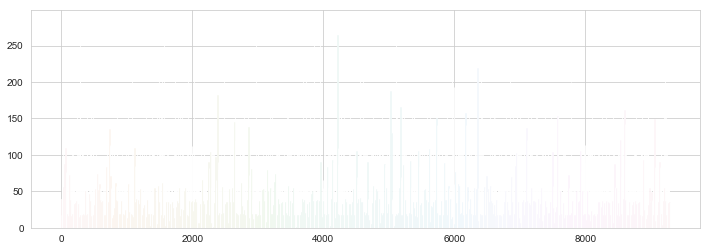

In [71]:
cnt_pro =clean_train['Author'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90)
plt.show();


In [72]:
def print_tweet(index):
    example = clean_train[clean_train.index == index][['Tweet', 'Author']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Author:', example[1])


In [76]:
print_tweet(0)

@handle Let's try and catch up live next week!
Author: 8746


In [97]:
train, test = train_test_split(clean_train, test_size=0.2, random_state=42)

In [128]:
from gensim.models.doc2vec import Doc2Vec
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [104]:
from gensim.models.doc2vec import TaggedDocument
def split(text):
    return text.split()

train_tagged = train.apply(lambda r: TaggedDocument(words=split(r['transform']), tags=[str(r.Author)]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=split(r['transform']), tags=[str(r.Author)]), axis=1)

In [105]:
train_tagged.values[0]

TaggedDocument(words=['move', 'soon', 'go', 'need', 'place', 'stay', 'anyone', 'need', 'new', 'roomie', 'pay', 'rent', 'stress'], tags=['9064'])

In [124]:
import multiprocessing
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

In [129]:
from sklearn import utils
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 262556/262556 [00:00<00:00, 2835747.05it/s]


In [131]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/wangyizhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangyizhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha


In [ ]:
%%time
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
load_pickle